In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
# Define Quidditch team stock mapping
teams = {
    "Gryffindor": "TSLA",
    "Slytherin": "AAPL",
    "Ravenclaw": "MSFT",
    "Hufflepuff": "AMZN"
}

def fetch_stock_data(team_name, start_date="2023-01-01", end_date="2025-03-28"):
    stock_symbol = teams[team_name]
    stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
    return stock_data[['Close']]  # We only need the closing prices

# Example usage
gryffindor_data = fetch_stock_data("Gryffindor")
gryffindor_data.tail()



YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,TSLA
Date,
2025-03-21,248.710007
2025-03-24,278.390015
2025-03-25,288.140015
2025-03-26,272.059998
2025-03-27,273.130005


In [4]:
def preprocess_data(stock_data, sequence_length=10):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data)

    X, y = [], []
    for i in range(len(scaled_data) - sequence_length):
        X.append(scaled_data[i:i + sequence_length])
        y.append(scaled_data[i + sequence_length])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Example usage
X, y, scaler = preprocess_data(gryffindor_data)


In [5]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Create model
model = build_lstm_model((10, 1))


c:\Users\Satyajit\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Split Data into Train and Test Sets
split = int(len(X) * 0.8)
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

# Train Model
model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - loss: 0.0238 - val_loss: 0.0315
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0145
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0101
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0075
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0025 - val_loss: 0.0084
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - val_loss: 0.0123
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0074
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0068
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0019 - val_

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step


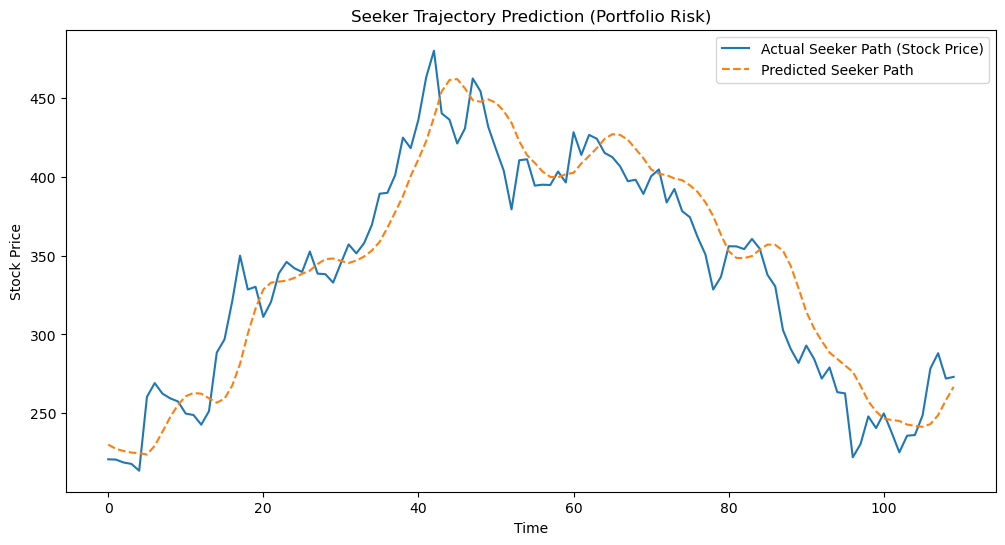

In [7]:
# Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Convert back to original price scale
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot Results
plt.figure(figsize=(12,6))
plt.plot(actual_prices, label="Actual Seeker Path (Stock Price)")
plt.plot(predictions, label="Predicted Seeker Path", linestyle="dashed")
plt.title("Seeker Trajectory Prediction (Portfolio Risk)")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [8]:
def calculate_risk_level(actual_prices, predictions, risk_tolerance):
    # Calculate Volatility
    daily_returns = np.diff(actual_prices, axis=0) / actual_prices[:-1]
    volatility = np.std(daily_returns)

    # Set Risk Labels
    if volatility > 0.03:
        risk_level = "High Risk (Unstable Seeker)"
    elif volatility > 0.015:
        risk_level = "Medium Risk (Balanced Seeker)"
    else:
        risk_level = "Low Risk (Stable Seeker)"

    # Decision Suggestion Based on Risk Tolerance
    decision = {
        "Low": "Safe Move (Defensive Strategy)",
        "Medium": "Moderate Move (Balanced Strategy)",
        "High": "Risky Move (Aggressive Trading)"
    }[risk_tolerance]

    return risk_level, volatility, decision

# Example Usage
risk_level, volatility, decision = calculate_risk_level(actual_prices, predictions, "Medium")
print(f"Risk Level: {risk_level}")
print(f"Volatility Score: {volatility:.4f}")
print(f"Suggested Decision: {decision}")


Risk Level: High Risk (Unstable Seeker)
Volatility Score: 0.0492
Suggested Decision: Moderate Move (Balanced Strategy)


In [10]:
import pandas as pd

# Load stock data (example)
stock_df = pd.read_csv(r"C:\Users\Satyajit\Desktop\HarryTheme\Quidditch-Capital-\stock_data.csv")

stock_df['date'] = pd.to_datetime(stock_df['date'])
stock_df.set_index('date', inplace=True)
teams = {"TSLA": "Tesla", "AAPL": "Apple"}


print(stock_df.head())  # Verify the data is loaded correctly


              TSLA    AAPL
date                      
2025-03-28  263.55  217.90
2025-03-27  273.13  223.85
2025-03-26  272.06  221.53
2025-03-25  288.14  223.75
2025-03-24  278.39  220.73


In [11]:
predicted_prices = model.predict(X_test)  # Make sure this runs before visualization


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [12]:
print(predicted_prices)
print(predicted_prices.shape)


[[0.32848588]
 [0.32119414]
 [0.31754535]
 [0.31487566]
 [0.3136816 ]
 [0.3116636 ]
 [0.32637104]
 [0.35042018]
 [0.375365  ]
 [0.396263  ]
 [0.41096354]
 [0.41650698]
 [0.41527247]
 [0.4073917 ]
 [0.3998243 ]
 [0.40696427]
 [0.4292817 ]
 [0.46620673]
 [0.517416  ]
 [0.5603998 ]
 [0.5929252 ]
 [0.6046139 ]
 [0.6063193 ]
 [0.6079676 ]
 [0.61260146]
 [0.61973697]
 [0.6250438 ]
 [0.63631696]
 [0.6445574 ]
 [0.64577717]
 [0.641625  ]
 [0.6380451 ]
 [0.6422887 ]
 [0.6491576 ]
 [0.6594333 ]
 [0.67421526]
 [0.69797206]
 [0.724743  ]
 [0.7518464 ]
 [0.78642833]
 [0.8149473 ]
 [0.84592277]
 [0.8861265 ]
 [0.9307109 ]
 [0.9501059 ]
 [0.95166147]
 [0.9358027 ]
 [0.9158148 ]
 [0.9129563 ]
 [0.91713434]
 [0.9111616 ]
 [0.89725566]
 [0.8771325 ]
 [0.84552014]
 [0.8220778 ]
 [0.8086863 ]
 [0.7940505 ]
 [0.78492457]
 [0.7842014 ]
 [0.7894703 ]
 [0.7918274 ]
 [0.80783707]
 [0.8205528 ]
 [0.83399326]
 [0.8497517 ]
 [0.8577176 ]
 [0.8564236 ]
 [0.84817094]
 [0.83250594]
 [0.8168797 ]
 [0.7977466 ]
 [0.79

In [13]:
predicted_prices = predicted_prices.reshape(1, -1)  # Ensures it matches (1, len(teams))


In [14]:
predicted_prices = predicted_prices.flatten()  # Converts to 1D array


In [15]:
print("Number of teams:", len(teams))
print("Predictions available:", predicted_prices.shape[1] if len(predicted_prices.shape) > 1 else len(predicted_prices))


Number of teams: 2
Predictions available: 110


In [16]:
import numpy as np

predicted_prices = np.array(predicted_prices).reshape(-1, len(teams))  # Ensure it's (X, 2)
predicted_prices = predicted_prices[-1]  # Take the most recent prediction


In [17]:
predicted_prices = predicted_prices[:2]  # Keep only the first two values


In [18]:
print("Fixed Predictions Shape:", predicted_prices.shape)
print(predicted_prices)  # Should print only 2 values


Fixed Predictions Shape: (2,)
[0.40398285 0.42693946]


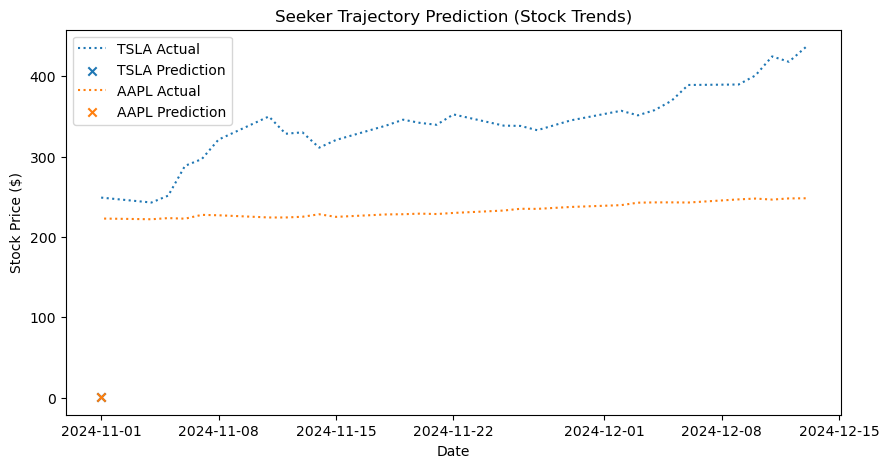

LSTM Model trained and predictions visualized.


In [19]:
# Visualization
plt.figure(figsize=(10, 5))
for idx, team in enumerate(teams.keys()):
    plt.plot(stock_df.index[-30:], stock_df[team][-30:], label=f"{team} Actual", linestyle='dotted')
    plt.scatter(stock_df.index[-1], predicted_prices[idx], label=f"{team} Prediction", marker='x')

plt.legend()
plt.title("Seeker Trajectory Prediction (Stock Trends)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.show()
print("LSTM Model trained and predictions visualized.")

In [20]:
model.save("lstm_stock_model.h5")


In [21]:
from tensorflow.keras.models import load_model

model = load_model("lstm_stock_model.h5")


In [23]:


# Mapping Quidditch Teams to Stock Symbols
teams = {
    "Gryffindor": "TSLA",
    "Slytherin": "AAPL",
    "Ravenclaw": "MSFT",
    "Hufflepuff": "AMZN"
}

# User Input
team_name = input("Enter Quidditch Team (Gryffindor/Slytherin/Ravenclaw/Hufflepuff): ")
risk_tolerance = input("Enter Risk Tolerance (Low/Medium/High): ")
time_frame = input("Enter Time Frame (Short-Term/Medium-Term/Long-Term): ")

# Fetch Stock Data
stock_symbol = teams.get(team_name, "TSLA")  # Default to TSLA if invalid
data = yf.download(stock_symbol, period="2y")  # Fetch last 2 years of data
prices = data[['Close']]

# Scale Data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_prices = scaler.fit_transform(prices)

# Get Last 10 Days for Prediction
X_test = np.array([scaled_prices[-10:]])  # Last 10 days data as input

# Predict
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)[0][0]  # Convert back to actual price

# Output Prediction
print(f"\n Predicted Seeker Path (Stock Price) for {team_name}: ${predicted_price:.2f}")

# Risk Analysis Logic
if risk_tolerance.lower() == "low":
    decision = "Safe Move (Defensive Strategy)"
elif risk_tolerance.lower() == "medium":
    decision = "Moderate Move (Balanced Strategy)"
else:
    decision = "Risky Move (Aggressive Trading)"

print(f"Suggested Strategy: {decision}")


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step

 Predicted Seeker Path (Stock Price) for Slytherin: $222.82
Suggested Strategy: Safe Move (Defensive Strategy)
